### Purpose:

- testing out osmnx functions
- testing attributing sidewalks to certain streets. 

In [8]:
import osmnx as ox
import matplotlib.pyplot as plt
from shapely import Polygon, MultiPolygon

from shapely.geometry import LineString, Polygon
from geopandas import GeoDataFrame, GeoSeries
import pandas as pd
import shapely
import numpy as np

import math
from libpysal.graph import Graph
from numpy.typing import NDArray
from pandas import DataFrame, Series

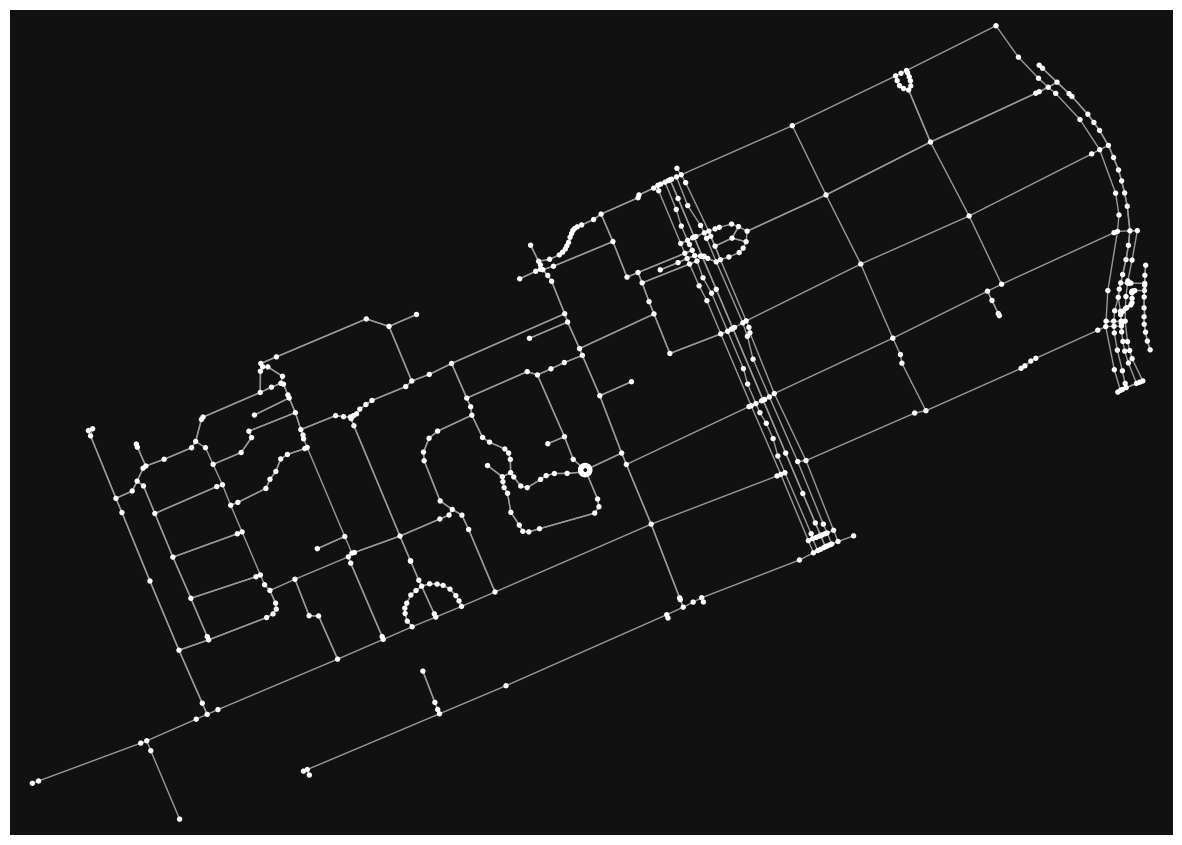

In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
from shapely import Polygon, MultiPolygon

# Load a graph from OpenStreetMap (example: Amsterdam city center)
place_name = "Helmersbuurt, Amsterdam, Netherlands"
graph = ox.graph_from_place(place_name, simplify=False)
gdf = ox.geocoder.geocode_to_gdf(place_name)

# Plot the graph
fig, ax = ox.plot_graph(graph, show=True, close=False, figsize=(15,15))
plt.show()

In [2]:
# Define a function to convert lists to strings (so we can save the building geodataframe because OSM includes a list of related nodes by default)
def convert_lists_to_strings(column):
    if column.dtype == 'object' and column.apply(lambda x: isinstance(x, list)).any():
        return column.apply(lambda x: ','.join(map(str, x)) if isinstance(x, list) else x)
    else:
        return column
    
tags = {"building": True}
only_geometry = gdf.geometry
osm_id = gdf.osm_id.loc[0]

# TODO: make sure that if there are multiple polygons that we append the different building footprints. Right now we're saving over, right?
# Handle Single Geometry: If you need to handle a specific geometry (e.g., the first one), you can extract it using gdf.geometry.iloc[0].

# Iterate over each polygon in the GeoDataFrame
for polygon in gdf.geometry:
    if polygon.is_valid and isinstance(polygon, (Polygon, MultiPolygon)):
        try:
            buildings = ox.features_from_polygon(polygon, tags)
            # save_dir = '../data/clean_data/solar/{OSMID}'
            # save_dir = save_dir.format(OSMID=osm_id)
            # if not os.path.exists(save_dir):
            #     os.makedirs(save_dir)
            # save_dir = save_dir + f'/{osm_id}_buildings.gpkg'
            buildings = buildings.apply(convert_lists_to_strings, axis=0)
            # buildings.to_file(save_dir, driver='GPKG')
            print(f'Success: Downloaded and saved {buildings.shape[0]} buildings.')
        except Exception as e:
            print(f"Error processing polygon: {e}")

Success: Downloaded and saved 1171 buildings.


In [3]:
buildings.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
nodes, edges = ox.graph_to_gdfs(graph)

In [5]:
m = edges.explore()
buildings.explore(m=m)
m

In [6]:
edges_repr = edges.to_crs(28992)
buildings_repr = buildings.to_crs(28992)

buildings_repr['area'] = buildings_repr.geometry.area

In [27]:
from shapely.geometry import LineString, Polygon
from geopandas import GeoDataFrame, GeoSeries
import pandas as pd
import shapely
import numpy as np

import math
from libpysal.graph import Graph
from numpy.typing import NDArray
from pandas import DataFrame, Series

def street_profile_with_sides(
    streets: GeoDataFrame,
    buildings: GeoDataFrame,
    distance: float = 10,
    tick_length: float = 50,
    height: None | pd.Series = None,
) -> pd.DataFrame:
    """
    Calculates street profile with building statistics disaggregated by side (east/west or north/south).

    Parameters
    ----------
    streets : GeoDataFrame
        Streets to analyze.
    buildings : GeoDataFrame
        Buildings along streets.
    distance : float, default=10
        Distance between ticks.
    tick_length : float, default=50
        Length of the perpendicular tick lines.
    height : pd.Series, optional
        Heights of buildings.

    Returns
    -------
    pd.DataFrame
        DataFrame with width, openness, width_deviation, and building statistics by side.
    """
    # Filter relevant buildings and streets
    inp, res = shapely.STRtree(streets.geometry).query(
        buildings.geometry, predicate="dwithin", distance=tick_length / 2
    )
    buildings_near_streets = buildings.iloc[inp].reset_index(drop=True)
    relevant_streets = streets.iloc[res].reset_index(drop=True)

    if height is not None:
        height = height.iloc[inp].reset_index(drop=True)

    # Calculate profile metrics
    results = []
    for i, street in enumerate(relevant_streets.geometry):
        # Generate ticks for the street
        coords = np.array(street.coords)
        angles = [shapely.geometry.LineString([coords[i], coords[i + 1]]) for i in range(len(coords) - 1)]
        ticks = generate_ticks(coords, distance, tick_length)
        tick_geometries = shapely.geometry.LineString(ticks)

        # # Classify buildings by side
        # building_sides = []
        # for building in buildings_near_streets.geometry:
        #     # Use spatial relationships to determine side
        #     side = determine_building_side(street, building)  # Custom function
        #     building_sides.append(side)
        building_sides = [
            determine_building_side(street, building) 
            for building in buildings_near_streets.geometry
            ]

        buildings_near_streets["side"] = building_sides

        # Compute statistics by side
        stats = buildings_near_streets.groupby("side").agg({
            "area": ["sum", "mean"],
            "height": ["mean", "std"]
        })

        # Add results
        results.append({
            "street_id": relevant_streets.index[i],
            "side_stats": stats.to_dict(),
            # Add other metrics like width, openness
        })

    return pd.DataFrame(results)

In [28]:
def determine_building_side(street: LineString, building: Polygon) -> str:
    """
    Determine whether a building is on the left or right side of a street segment.

    Parameters
    ----------
    street : LineString
        The street segment.
    building : Polygon
        The building polygon.

    Returns
    -------
    str
        'left' if the building is on the left side, 'right' if on the right side.
    """
    # Get the street's central coordinates
    street_coords = np.array(street.coords)
    street_start, street_end = street_coords[0], street_coords[-1]

    # Calculate the direction vector of the street
    direction_vector = np.array(street_end) - np.array(street_start)

    # Calculate a perpendicular vector to determine "left" and "right"
    perpendicular_vector = np.array([-direction_vector[1], direction_vector[0]])

    # Get the centroid of the building
    building_centroid = np.array(building.centroid.coords[0])

    # Vector from the street start to the building centroid
    to_building_vector = building_centroid - street_start

    # Compute dot product to determine the side
    dot_product = np.dot(to_building_vector, perpendicular_vector)

    return "left" if dot_product > 0 else "right"

# @njit
def generate_ticks(list_points, end_markers, tick_length):
    ticks = np.empty((len(list_points) * 2, 4), dtype=float)

    for i in range(len(list_points)):
        tick_pos = i * 2
        end = end_markers[i]
        pt = list_points[i]

        if end:
            ticks[tick_pos, :] = np.array([pt[0], pt[1], pt[0], pt[1]])
            ticks[tick_pos + 1, :] = np.array([pt[0], pt[1], pt[0], pt[1]])
        else:
            next_pt = list_points[i + 1]
            njit_angle1 = _get_angle_njit(pt[0], pt[1], next_pt[0], next_pt[1])
            njit_end_1 = _get_point_njit(
                pt[0], pt[1], njit_angle1 + 90, tick_length / 2
            )
            njit_angle2 = _get_angle_njit(njit_end_1[0], njit_end_1[1], pt[0], pt[1])
            njit_end_2 = _get_point_njit(
                njit_end_1[0], njit_end_1[1], njit_angle2, tick_length
            )
            ticks[tick_pos, :] = np.array([njit_end_1[0], njit_end_1[1], pt[0], pt[1]])
            ticks[tick_pos + 1, :] = np.array(
                [njit_end_2[0], njit_end_2[1], pt[0], pt[1]]
            )

    return ticks


### Combined:

In [ ]:
from shapely.geometry import LineString, Polygon
from geopandas import GeoDataFrame, GeoSeries
import pandas as pd
import shapely
import numpy as np

import math
from libpysal.graph import Graph
from numpy.typing import NDArray
from pandas import DataFrame, Series

def street_profile_with_sides(
    streets: GeoDataFrame,
    buildings: GeoDataFrame,
    distance: float = 10,
    tick_length: float = 50,
    height: None | pd.Series = None,
) -> pd.DataFrame:
    """
    Calculates street profile with building statistics disaggregated by side (east/west or north/south).

    Parameters
    ----------
    streets : GeoDataFrame
        Streets to analyze.
    buildings : GeoDataFrame
        Buildings along streets.
    distance : float, default=10
        Distance between ticks.
    tick_length : float, default=50
        Length of the perpendicular tick lines.
    height : pd.Series, optional
        Heights of buildings.

    Returns
    -------
    pd.DataFrame
        DataFrame with width, openness, width_deviation, and building statistics by side.
    """
    # Filter relevant buildings and streets
    inp, res = shapely.STRtree(streets.geometry).query(
        buildings.geometry, predicate="dwithin", distance=tick_length / 2
    )
    buildings_near_streets = buildings.iloc[inp].reset_index(drop=True)
    relevant_streets = streets.iloc[res].reset_index(drop=True)

    if height is not None:
        height = height.iloc[inp].reset_index(drop=True)

    # Calculate profile metrics
    results = []
    for i, street in enumerate(relevant_streets.geometry):
        # Generate ticks for the street
        coords = np.array(street.coords)
        angles = [shapely.geometry.LineString([coords[i], coords[i + 1]]) for i in range(len(coords) - 1)]
        ticks = generate_ticks(coords, distance, tick_length)
        tick_geometries = shapely.geometry.LineString(ticks)

        # # Classify buildings by side
        # building_sides = []
        # for building in buildings_near_streets.geometry:
        #     # Use spatial relationships to determine side
        #     side = determine_building_side(street, building)  # Custom function
        #     building_sides.append(side)
        building_sides = [
            determine_building_side(street, building) 
            for building in buildings_near_streets.geometry
            ]

        buildings_near_streets["side"] = building_sides

        # Compute statistics by side
        stats = buildings_near_streets.groupby("side").agg({
            "area": ["sum", "mean"],
            "height": ["mean", "std"]
        })

        # Add results
        results.append({
            "street_id": relevant_streets.index[i],
            "side_stats": stats.to_dict(),
            # Add other metrics like width, openness
        })

    return pd.DataFrame(results)

def determine_building_side(street: LineString, building: Polygon) -> str:
    """
    Determine whether a building is on the left or right side of a street segment.

    Parameters
    ----------
    street : LineString
        The street segment.
    building : Polygon
        The building polygon.

    Returns
    -------
    str
        'left' if the building is on the left side, 'right' if on the right side.
    """
    # Get the street's central coordinates
    street_coords = np.array(street.coords)
    street_start, street_end = street_coords[0], street_coords[-1]

    # Calculate the direction vector of the street
    direction_vector = np.array(street_end) - np.array(street_start)

    # Calculate a perpendicular vector to determine "left" and "right"
    perpendicular_vector = np.array([-direction_vector[1], direction_vector[0]])

    # Get the centroid of the building
    building_centroid = np.array(building.centroid.coords[0])

    # Vector from the street start to the building centroid
    to_building_vector = building_centroid - street_start

    # Compute dot product to determine the side
    dot_product = np.dot(to_building_vector, perpendicular_vector)

    return "left" if dot_product > 0 else "right"

# @njit
def generate_ticks(list_points, end_markers, tick_length):
    ticks = np.empty((len(list_points) * 2, 4), dtype=float)

    for i in range(len(list_points)):
        tick_pos = i * 2
        end = end_markers[i]
        pt = list_points[i]

        if end:
            ticks[tick_pos, :] = np.array([pt[0], pt[1], pt[0], pt[1]])
            ticks[tick_pos + 1, :] = np.array([pt[0], pt[1], pt[0], pt[1]])
        else:
            next_pt = list_points[i + 1]
            njit_angle1 = _get_angle_njit(pt[0], pt[1], next_pt[0], next_pt[1])
            njit_end_1 = _get_point_njit(
                pt[0], pt[1], njit_angle1 + 90, tick_length / 2
            )
            njit_angle2 = _get_angle_njit(njit_end_1[0], njit_end_1[1], pt[0], pt[1])
            njit_end_2 = _get_point_njit(
                njit_end_1[0], njit_end_1[1], njit_angle2, tick_length
            )
            ticks[tick_pos, :] = np.array([njit_end_1[0], njit_end_1[1], pt[0], pt[1]])
            ticks[tick_pos + 1, :] = np.array(
                [njit_end_2[0], njit_end_2[1], pt[0], pt[1]]
            )

    return ticks

# angle between two points
# @njit
def _get_angle_njit(x1, y1, x2, y2):
    """
    pt1, pt2 : tuple
    """
    x_diff = x2 - x1
    y_diff = y2 - y1
    return math.degrees(math.atan2(y_diff, x_diff))


# get the second end point of a tick
# p1 = bearing + 90
# @njit
def _get_point_njit(x1, y1, bearing, dist):
    bearing = math.radians(bearing)
    x = x1 + dist * math.cos(bearing)
    y = y1 + dist * math.sin(bearing)
    return np.array((x, y))

profile = street_profile_with_sides(edges_repr, buildings_repr)



### Further experiments

In [9]:
def street_profile_with_sides(
    streets: GeoDataFrame,
    buildings: GeoDataFrame,
    distance: float = 10,
    tick_length: float = 50,
    height: None | pd.Series = None,
) -> pd.DataFrame:
    """
    Calculates street profile with building statistics disaggregated by side (east/west or north/south).
    """
    # Filter relevant buildings and streets
    inp, res = shapely.STRtree(streets.geometry).query(
        buildings.geometry, predicate="dwithin", distance=tick_length / 2
    )
    buildings_near_streets = buildings.iloc[inp].reset_index(drop=True)
    relevant_streets = streets.iloc[res].reset_index(drop=True)

    if height is not None:
        height = height.iloc[inp].reset_index(drop=True)

    # Calculate profile metrics
    results = []
    for i, street in enumerate(relevant_streets.geometry):
        # Generate ticks for the street
        coords = np.array(street.coords)
        
        # Create end markers
        starts = np.zeros(len(coords), dtype=bool)
        ends = np.zeros(len(coords), dtype=bool)
        starts[0] = True  # Mark first point
        ends[-1] = True  # Mark last point
        end_markers = starts | ends

        # Generate tick geometries
        ticks = generate_ticks(coords, end_markers, tick_length)

        # Classify buildings by side
        building_sides = [
            determine_building_side(street, building)
            for building in buildings_near_streets.geometry
        ]
        buildings_near_streets["side"] = building_sides

        # Compute statistics by side
        stats = buildings_near_streets.groupby("side").agg({
            "area": ["sum", "mean"],
            # "height": ["mean", "std"]
        })

        # Add results
        results.append({
            "street_id": relevant_streets.index[i],
            "side_stats": stats.to_dict(),
        })

    return pd.DataFrame(results)

def determine_building_side(street: LineString, building: Polygon) -> str:
    """
    Determine whether a building is on the north, south, east, or west side of a street segment.

    Parameters
    ----------
    street : LineString
        The street segment.
    building : Polygon
        The building polygon.

    Returns
    -------
    str
        One of 'north', 'south', 'east', 'west' depending on the relative location of the building.
    """
    # Get the street's central coordinates
    street_coords = np.array(street.coords)
    street_start, street_end = street_coords[0], street_coords[-1]

    # Calculate the direction vector of the street
    direction_vector = np.array(street_end) - np.array(street_start)

    # Normalize direction vector to compute orientation
    if np.linalg.norm(direction_vector) != 0:
        direction_vector = direction_vector / np.linalg.norm(direction_vector)

    # Compute street orientation angle (in degrees)
    angle = math.degrees(math.atan2(direction_vector[1], direction_vector[0]))

    # Get the centroid of the building
    building_centroid = np.array(building.centroid.coords[0])

    # Calculate the vector from the street to the building centroid
    to_building_vector = building_centroid - street_start

    # Project the building vector onto the cardinal axes
    north_south_component = to_building_vector[1]
    east_west_component = to_building_vector[0]

    # Determine the side based on the orientation
    if -45 <= angle <= 45:  # Street is oriented east-west
        return "north" if north_south_component > 0 else "south"
    elif 45 < angle <= 135:  # Street is oriented north-south
        return "west" if east_west_component < 0 else "east"
    elif -135 <= angle < -45:  # Street is oriented south-north
        return "west" if east_west_component < 0 else "east"
    else:  # Street is oriented west-east
        return "south" if north_south_component < 0 else "north"

def generate_ticks(list_points, end_markers, tick_length):
    """
    Generate tick geometries along a line segment.
    """
    ticks = np.empty((len(list_points) * 2, 4), dtype=float)

    for i in range(len(list_points)):
        tick_pos = i * 2
        end = end_markers[i]
        pt = list_points[i]

        if end:
            ticks[tick_pos, :] = np.array([pt[0], pt[1], pt[0], pt[1]])
            ticks[tick_pos + 1, :] = np.array([pt[0], pt[1], pt[0], pt[1]])
        else:
            next_pt = list_points[i + 1]
            njit_angle1 = _get_angle_njit(pt[0], pt[1], next_pt[0], next_pt[1])
            njit_end_1 = _get_point_njit(
                pt[0], pt[1], njit_angle1 + 90, tick_length / 2
            )
            njit_angle2 = _get_angle_njit(njit_end_1[0], njit_end_1[1], pt[0], pt[1])
            njit_end_2 = _get_point_njit(
                njit_end_1[0], njit_end_1[1], njit_angle2, tick_length
            )
            ticks[tick_pos, :] = np.array([njit_end_1[0], njit_end_1[1], pt[0], pt[1]])
            ticks[tick_pos + 1, :] = np.array(
                [njit_end_2[0], njit_end_2[1], pt[0], pt[1]]
            )

    return ticks

In [13]:
profile = street_profile_with_sides(edges_repr, buildings_repr)
print(profile)

KeyboardInterrupt: 

In [36]:
buildings_repr.head()

addr:city addr:housenumber addr:street  \
element_type osmid                                             
way          44532012       NaN              NaN         NaN   
             44532017       NaN              NaN         NaN   
             44532020       NaN              NaN         NaN   
             44532021       NaN              NaN         NaN   
             44532022       NaN              NaN         NaN   

                                                                geometry  \
element_type osmid                                                         
way          44532012  POLYGON ((119582.318 486293.456, 119584.314 48...   
             44532017  POLYGON ((119871.162 486242.845, 119874.999 48...   
             44532020  POLYGON ((119681.017 486367.287, 119681.749 48...   
             44532021  POLYGON ((119611.386 486325.170, 119592.947 48...   
             44532022  POLYGON ((119745.544 486189.119, 119729.755 48...   

                         source      amenity                          name  \
element_type osmid                                                           
way          44532012       BAG          NaN                           NaN   
             44532017       BAG          NaN  Vrouwenkliniek, Paviljoen 18   
             44532020       BAG          NaN                           NaN   
             44532021       BAG  arts_centre                       LAB 111   
             44532022  3dShapes          NaN             Anna Reynvaanflat   

                      operator  \
element_type osmid               
way          44532012      NaN   
             44532017      NaN   
             44532020      NaN   
             44532021      NaN   
             44532022      NaN   

                                                                   nodes  \
element_type osmid                                                         
way          44532012  1590069044,565661607,565661604,2809972948,5656...   
             44532017  2809972109,2809971991,2809972080,565661722,280...   
             44532020  2809973388,508506882,2809973377,2809973373,565...   
             44532021  2809973285,1590069057,2809973250,806636214,280...   
             44532022  565661633,565661624,2820238715,565661627,56566...   

                         building  ... internet_access not:brand:wikidata  \
element_type osmid                 ...                                      
way          44532012  industrial  ...             NaN                NaN   
             44532017         yes  ...             NaN                NaN   
             44532020  apartments  ...             NaN                NaN   
             44532021         yes  ...             NaN                NaN   
             44532022  apartments  ...             NaN                NaN   

                      opening_hours outdoor_seating phone takeaway  \
element_type osmid                                                   
way          44532012           NaN             NaN   NaN      NaN   
             44532017           NaN             NaN   NaN      NaN   
             44532020           NaN             NaN   NaN      NaN   
             44532021           NaN             NaN   NaN      NaN   
             44532022           NaN             NaN   NaN      NaN   

                      social_facility ways type         area  
element_type osmid                                            
way          44532012             NaN  NaN  NaN    45.125928  
             44532017             NaN  NaN  NaN  2072.180096  
             44532020             NaN  NaN  NaN   420.922203  
             44532021             NaN  NaN  NaN  1292.379972  
             44532022             NaN  NaN  NaN   309.960713  

[5 rows x 54 columns]

### only buildings that intersect

In [22]:
def street_profile_with_sides(
    streets: GeoDataFrame,
    buildings: GeoDataFrame,
    distance: float = 10,
    tick_length: float = 50,
    height: None | pd.Series = None,
) -> pd.DataFrame:
    """
    Calculates street profile with building statistics disaggregated by side (east/west or north/south).
    """
    results = []

    for i, street in enumerate(streets.geometry):
        # Generate coordinates and end markers
        coords = np.array(street.coords)
        starts = np.zeros(len(coords), dtype=bool)
        ends = np.zeros(len(coords), dtype=bool)
        starts[0] = True
        ends[-1] = True
        end_markers = starts | ends

        # Generate tick geometries
        ticks = generate_ticks(coords, end_markers, tick_length)
        tick_lines = [LineString(tick.reshape(2, 2)) for tick in ticks]

        # Find buildings intersected by ticks
        intersected_buildings = buildings[buildings.geometry.apply(
            lambda b: any(tick.intersects(b) for tick in tick_lines)
        )]

        # Skip if no intersected buildings
        if intersected_buildings.empty:
            continue

        # Classify buildings by side
        building_sides = [
            determine_building_side(street, building)
            for building in intersected_buildings.geometry
        ]
        intersected_buildings["side"] = building_sides

        # Compute statistics by side
        stats = intersected_buildings.groupby("side").agg({
            "area": ["sum", "mean"],
            "height": ["mean", "std"] if height is not None else {}
        })

        # Add results
        results.append({
            "street_id": streets.index[i],
            "side_stats": stats.to_dict(),
        })

    return pd.DataFrame(results)


def generate_ticks(list_points, end_markers, tick_length):
    """
    Generate tick geometries along a line segment.
    """
    ticks = np.empty((len(list_points) * 2, 4), dtype=float)

    for i in range(len(list_points)):
        tick_pos = i * 2
        end = end_markers[i]
        pt = list_points[i]

        if end:
            ticks[tick_pos, :] = np.array([pt[0], pt[1], pt[0], pt[1]])
            ticks[tick_pos + 1, :] = np.array([pt[0], pt[1], pt[0], pt[1]])
        else:
            next_pt = list_points[i + 1]
            njit_angle1 = _get_angle_njit(pt[0], pt[1], next_pt[0], next_pt[1])
            njit_end_1 = _get_point_njit(
                pt[0], pt[1], njit_angle1 + 90, tick_length / 2
            )
            njit_angle2 = _get_angle_njit(njit_end_1[0], njit_end_1[1], pt[0], pt[1])
            njit_end_2 = _get_point_njit(
                njit_end_1[0], njit_end_1[1], njit_angle2, tick_length
            )
            ticks[tick_pos, :] = np.array([njit_end_1[0], njit_end_1[1], pt[0], pt[1]])
            ticks[tick_pos + 1, :] = np.array(
                [njit_end_2[0], njit_end_2[1], pt[0], pt[1]]
            )

    return ticks


def determine_building_side(street: LineString, building: Polygon) -> str:
    """
    Determine whether a building is on the north, south, east, or west side of a street segment.

    Parameters
    ----------
    street : LineString
        The street segment.
    building : Polygon
        The building polygon.

    Returns
    -------
    str
        One of 'north', 'south', 'east', 'west' depending on the relative location of the building.
    """
    # Get the street's central coordinates
    street_coords = np.array(street.coords)
    street_start, street_end = street_coords[0], street_coords[-1]

    # Calculate the direction vector of the street
    direction_vector = np.array(street_end) - np.array(street_start)

    # Normalize direction vector to compute orientation
    if np.linalg.norm(direction_vector) != 0:
        direction_vector = direction_vector / np.linalg.norm(direction_vector)

    # Compute street orientation angle (in degrees)
    angle = math.degrees(math.atan2(direction_vector[1], direction_vector[0]))

    # Get the centroid of the building
    building_centroid = np.array(building.centroid.coords[0])

    # Calculate the vector from the street to the building centroid
    to_building_vector = building_centroid - street_start

    # Project the building vector onto the cardinal axes
    north_south_component = to_building_vector[1]
    east_west_component = to_building_vector[0]

    # Determine the side based on the orientation
    if -45 <= angle <= 45:  # Street is oriented east-west
        return "north" if north_south_component > 0 else "south"
    elif 45 < angle <= 135:  # Street is oriented north-south
        return "west" if east_west_component < 0 else "east"
    elif -135 <= angle < -45:  # Street is oriented south-north
        return "west" if east_west_component < 0 else "east"
    else:  # Street is oriented west-east
        return "south" if north_south_component < 0 else "north"


In [23]:
profile = street_profile_with_sides(edges_repr, buildings_repr)
print(profile)

/opt/anaconda3/envs/throwing_shade/lib/python3.12/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


SpecificationError: nested renamer is not supported

In [21]:
# Example street and building GeoDataFrames
single_street = edges_repr.iloc[[0]]
nearby_buildings = buildings_repr

# Run the updated function
profile = street_profile_with_sides(edges_repr, nearby_buildings, distance=10, tick_length=50)

# Inspect results
print(profile)

/opt/anaconda3/envs/throwing_shade/lib/python3.12/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


SpecificationError: nested renamer is not supported

### Visualise a single street

In [15]:
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point
import geopandas as gpd

def visualize_street_profile(street, buildings, tick_length=50, distance=10):
    """
    Visualizes the step-by-step process for determining the street profile for a single street.

    Parameters
    ----------
    street : LineString
        The street segment to analyze.
    buildings : GeoDataFrame
        The buildings near the street.
    tick_length : float, default=50
        Length of perpendicular ticks.
    distance : float, default=10
        Distance between ticks.

    Returns
    -------
    None
    """
    # Generate coordinates and end markers
    coords = np.array(street.coords)
    starts = np.zeros(len(coords), dtype=bool)
    ends = np.zeros(len(coords), dtype=bool)
    starts[0] = True
    ends[-1] = True
    end_markers = starts | ends

    # Generate ticks
    ticks = generate_ticks(coords, end_markers, tick_length)

    # Initialize plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot the street
    street_gdf = gpd.GeoSeries([street])
    street_gdf.plot(ax=ax, color="blue", linewidth=2, label="Street")

    # Plot buildings
    buildings.plot(ax=ax, color="green", alpha=0.5, label="Buildings")

    # Plot building centroids
    centroids = buildings.geometry.centroid
    gpd.GeoSeries(centroids).plot(ax=ax, color="red", label="Building Centroids")

    # Plot ticks
    for tick_coords in ticks.reshape(-1, 2, 2):
        tick_line = LineString(tick_coords)
        gpd.GeoSeries([tick_line]).plot(ax=ax, color="black", linestyle="--", alpha=0.8)

    # Annotate building sides
    for building in buildings.geometry:
        side = determine_building_side(street, building)
        centroid = building.centroid
        ax.annotate(
            side.capitalize(),
            (centroid.x, centroid.y),
            color="purple",
            fontsize=10,
            ha="center",
            va="center",
        )

    # Add legend and titles
    ax.set_title("Step-by-Step Street Profile Visualization")
    ax.legend()
    plt.show()

/var/folders/qg/ghhvk02j7t3f3b9th5d2412rxxy23f/T/ipykernel_99492/1314187209.py:69: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


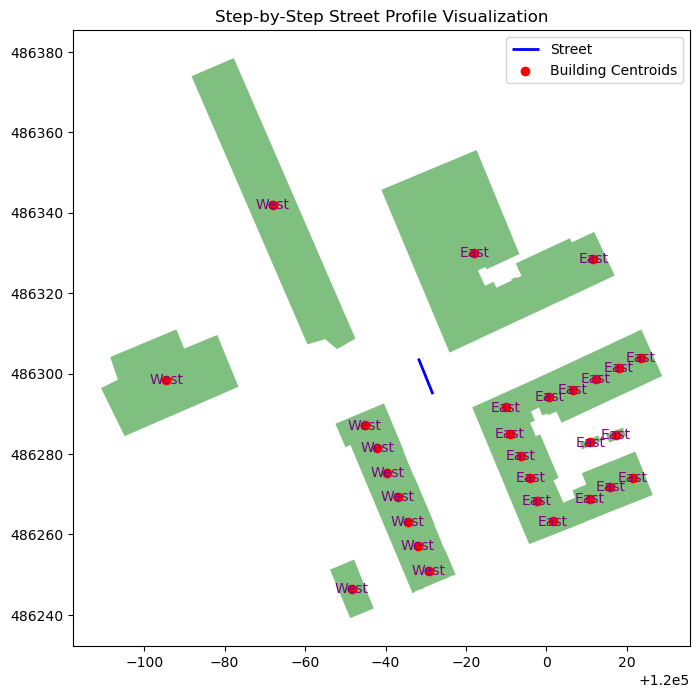

In [16]:
# Select a single street and nearby buildings
single_street = edges_repr.geometry.iloc[0]
nearby_buildings = buildings_repr[buildings_repr.geometry.distance(single_street) < 50]

# Visualize the process
visualize_street_profile(single_street, nearby_buildings, tick_length=50, distance=10)